In [1]:
import common
import importlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import socket
import plotting

import matplotlib.style
matplotlib.style.use('classic')

# Show all columns and rows in a dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# Size of the axis overflow indicators
OVERFLOW_FONT_SIZE = 6

In [2]:
# graphalytics inserts
pers_experiments = "num_threads_read == 0 and (hostname == 'scyper22')"

data_ins = common.import_gfe("view_graphalytics_inserts").query(pers_experiments).copy() # data from the experiments
data_ins["build_frequency"].fillna(pd.Timedelta(0), inplace=True) # replace NaT with 0, otherwise the records are ignored in the group by

data_ins = data_ins.query("((block_size == 512) and library == 'sortledton.3') or library != 'sortledton.3'")

# graphalytics load
data_load = common.import_gfe("view_graphalytics_load").query(pers_experiments).copy()
# shape the dataframe as data_ins
data_load["build_frequency"] = pd.Timedelta(0)
data_load["build_frequency_secs"] = np.NaN
data_load["num_snapshots_created"] = 0
data_load["num_threads_write"] = 0
data_load["block_size"] = -1

data = pd.concat([data_ins, data_load])
data["validate_inserts"].fillna("0", inplace=True)
data["validate_output"].fillna("0", inplace=True)


data = data.query("validate_inserts == '0' and validate_output == '0'")

data = data.groupby(["library", "compiler_family", "graph", "build_frequency","num_threads_read", "num_threads_write", "algorithm"]) \
    .agg(completion_time=("median_secs", "median"), count=("median_secs", "count"), ct_std=("median_secs", "std"))
data["cov"] = data["ct_std"] / data["completion_time"]
data

completion_time  \
library                        compiler_family graph          build_frequency num_threads_read num_threads_write algorithm                    
baseline_v3                    gcc             dota-league    0 days 00:00:00 0                1                 bfs               7.538361   
                                                                                                                 cdlp             52.287221   
                                                                                                                 lcc            1882.367861   
                                                                                                                 pagerank         74.906913   
                                                                                                                 sssp              3.600868   
                                                                                                                 wcc              10.388922   
                                               graph500-24    0 days 00:00:00 0                1                 bfs             125.555598   
                                                                                                                 cdlp                   NaN   
                                                                                                                 lcc                    NaN   
                                                                                                                 pagerank       1266.711086   
                                                                                                                 sssp             81.206667   
                                                                                                                 wcc             322.996458   
                                               uniform-24     0 days 00:00:00 0                1                 bfs             153.350156   
                                                                                                                 cdlp           1797.668647   
                                                                                                                 lcc             421.805360   
                                                                                                                 pagerank       1628.261105   
                                                                                                                 sssp            100.996033   
                                                                                                                 wcc             186.280122   
csr3                           gcc             com-friendster 0 days 00:00:00 0                0                 bfs               1.027292   
                                                                                                                 cdlp            160.783570   
                                                                                                                 lcc             835.651810   
                                                                                                                 pagerank         31.602786   
                                                                                                                 sssp             43.221247   
                                                                                                                 wcc              10.248647   
                                               dota-league    0 days 00:00:00 0                0                 bfs               0.000805   
                                                                                                                 cdlp              1.148272   
                                                                                                                 lcc    

In [3]:
data_csr = data

In [4]:
data_high_err = data.query("cov > 0.1")
data_high_err

completion_time  \
library                   compiler_family graph          build_frequency num_threads_read num_threads_write algorithm                    
csr3-lcc                  gcc             com-friendster 0 days 00:00:00 0                0                 cdlp            296.952842   
                                                                                                            sssp             53.552172   
                                          graph500-22    0 days 00:00:00 0                0                 sssp              0.901464   
                                          graph500-24    0 days 00:00:00 0                0                 cdlp             32.441325   
                                          graph500-26    0 days 00:00:00 0                0                 cdlp            104.740893   
                                                                                                            sssp             32.456623   
                                          uniform-24     0 days 00:00:00 0                0                 cdlp             24.325043   
                                          uniform-26     0 days 00:00:00 0                0                 cdlp             98.890649   
csr3-lcc-numa             gcc             com-friendster 0 days 00:00:00 0                0                 cdlp            177.237292   
                                                                                                            sssp             59.441738   
                                          dota-league    0 days 00:00:00 0                0                 bfs               0.000727   
                                          graph500-22    0 days 00:00:00 0                0                 cdlp              8.122214   
                                          graph500-24    0 days 00:00:00 0                0                 cdlp             14.926092   
                                          graph500-26    0 days 00:00:00 0                0                 cdlp            140.942144   
                                          uniform-24     0 days 00:00:00 0                0                 cdlp             23.132612   
                                          uniform-26     0 days 00:00:00 0                0                 cdlp            180.167332   
g1_v6-ref-ignore-build    gcc             graph500-22    0 days 00:00:00 0                20                cdlp              9.974392   
                                          graph500-24    0 days 00:00:00 0                20                cdlp             31.449167   
                                          graph500-26    0 days 00:00:00 0                20                bfs               5.189803   
                                                                                                            cdlp            135.322500   
                                          uniform-24     0 days 00:00:00 0                20                cdlp             47.025972   
                                          uniform-26     0 days 00:00:00 0                20                cdlp            186.268955   
                                                                                                            wcc             539.230175   
livegraph3_ro             gcc             com-friendster 0 days 00:00:00 0                20                cdlp            290.855899   
                                          graph500-22    0 days 00:00:00 0                20                cdlp              6.935005   
                                                                                                            wcc               0.390946   
                                          graph500-24    0 days 00:00:00 0                20                cdlp             27.848318   
                                          uniform-24     0 days 00:00:00 0                20                cdlp     

In [5]:
low_count = data.query("count < 5").copy()
low_count = low_count.query("(library == 'llama8-ref' and build_frequency != '00:00:00') or library != 'llama8-ref'")
low_count = low_count.query("num_threads_write == 0 or num_threads_write == 56")
low_count = low_count.query("library != 'sortledton'")
low_count = low_count.query("library != 'sortledton.1'")
low_count

completion_time  \
library                        compiler_family graph          build_frequency num_threads_read num_threads_write algorithm                    
csr3                           gcc             com-friendster 0 days          0                0                 bfs               1.027292   
                                                                                                                 cdlp            160.783570   
                                                                                                                 lcc             835.651810   
                                                                                                                 pagerank         31.602786   
                                                                                                                 sssp             43.221247   
                                                                                                                 wcc              10.248647   
                                               dota-league    0 days          0                0                 bfs               0.000805   
                                                                                                                 cdlp              1.148272   
                                                                                                                 lcc             363.353080   
                                                                                                                 pagerank          0.137712   
                                                                                                                 sssp              0.402430   
                                                                                                                 wcc               0.029459   
                                               graph500-22    0 days          0                0                 bfs               0.036871   
                                                                                                                 cdlp              8.128233   
                                                                                                                 lcc             306.267269   
                                                                                                                 pagerank          0.409062   
                                                                                                                 sssp              0.861648   
                                                                                                                 wcc               0.158084   
                                               graph500-24    0 days          0                0                 bfs               0.137484   
                                                                                                                 cdlp             33.922899   
                                                                                                                 lcc            2236.280409   
                                                                                                                 pagerank          2.724284   
                                                                                                                 sssp              6.828722   
                                                                                                                 wcc               0.939615   
                                               graph500-26    0 days          0                0                 bfs               0.498458   
                                                                                                                 cdlp             70.469243   
                                                                                                                 lcc    

List of available executions:

In [6]:
data = data.unstack("algorithm")[("completion_time")]
data.index.set_names("compiler", level=1, inplace=True)

fn_join_threads = lambda grp: ", ".join(map(str, grp.unique()))
data.reset_index().groupby(["library", "compiler"]).agg(num_threads_w=("num_threads_write", fn_join_threads), num_threads_r=("num_threads_read", fn_join_threads))

,,num_threads_w,num_threads_r
library,compiler,,
baseline_v3,gcc,1,0
csr3,gcc,0,0
csr3-lcc,gcc,0,0
csr3-lcc-numa,gcc,0,0
g1_v6-ref-ignore-build,gcc,20,0
livegraph3_ro,gcc,20,0
llama8-ref,gcc,16,0
mb-csr.6,gcc,56,0
mb-csr.8,gcc,56,0


### CSR

In [7]:
csr = data.loc[("csr3-lcc", "gcc")].droplevel([1,2,3])
csr["lcc_std"] = data.loc[("csr3", "gcc")].droplevel([1,2,3]).rename(columns = {"lcc": "lcc_std"})["lcc_std"]
csr_numa = data.loc[("csr3-lcc-numa", "gcc")].droplevel([1,2,3])
csr_numa["lcc_std"] = data.loc[("csr3", "gcc")].droplevel([1,2,3]).rename(columns = {"lcc": "lcc_std"})["lcc_std"]
mb_csr = data.loc[("mb-csr.8", "gcc")].droplevel([1,2,3])
mb_csr["lcc_std"] = data.loc[("csr3", "gcc")].droplevel([1,2,3]).rename(columns = {"lcc": "lcc_std"})["lcc_std"]
min_csr = mb_csr.combine(csr_numa, np.minimum)
csr = csr[["bfs", "cdlp", "lcc_std", "lcc", "pagerank", "sssp", "wcc"]] # reoder the columns
csr = pd.concat([csr, csr_numa, mb_csr, min_csr], names=["library"], keys=["csr", "csr_numa", "mb_csr", "min_csr"]) # prepend the key `csr`

min_csr

algorithm,bfs,cdlp,lcc,pagerank,sssp,wcc,lcc_std
graph,,,,,,,
com-friendster,0.970899,177.237292,59.470150,30.603569,49.037404,10.068403,835.651810
dota-league,0.000727,1.107514,49.816105,0.105036,0.245215,0.023842,363.353080
graph500-22,0.033258,3.703384,8.417857,0.337325,0.739230,0.118526,306.267269
graph500-24,0.131544,14.926092,51.627964,1.786068,4.717334,0.576570,2236.280409
graph500-26,0.480766,119.647970,309.646945,10.626454,26.432848,3.006076,NaN
uniform-24,0.148202,23.132612,2.816906,3.309615,6.443192,1.012159,21.949081
uniform-26,0.518993,132.497073,13.111546,18.350899,34.104711,6.210624,92.364151


In [8]:

mb_csr

algorithm,bfs,cdlp,lcc,pagerank,sssp,wcc,lcc_std
graph,,,,,,,
com-friendster,1.125382,227.241485,59.470150,30.603569,49.037404,16.095385,835.651810
dota-league,0.000776,1.107514,49.816105,0.140827,0.404890,0.029735,363.353080
graph500-22,0.037814,3.703384,8.417857,0.337325,0.826469,0.118526,306.267269
graph500-24,0.139064,16.663601,51.627964,1.786068,4.717334,0.576570,2236.280409
graph500-26,0.514324,119.647970,309.646945,10.626454,29.054993,3.006076,NaN
uniform-24,0.152608,40.478046,3.251787,3.344918,9.652527,1.012159,21.949081
uniform-26,0.563581,132.497073,14.869173,18.527266,46.767923,7.454135,92.364151


In [9]:
compare = mb_csr / csr_numa
compare


algorithm,bfs,cdlp,lcc,pagerank,sssp,wcc,lcc_std
graph,,,,,,,
com-friendster,1.159113,1.282131,0.990628,0.980019,0.824966,1.598604,1.0
dota-league,1.067400,0.945277,0.928568,1.340745,1.651161,1.247148,1.0
graph500-22,1.136990,0.455957,0.705525,0.849108,1.118013,0.769330,1.0
graph500-24,1.057167,1.116407,0.716198,0.664393,0.977228,0.620624,1.0
graph500-26,1.069801,0.848915,0.647426,0.699060,1.099200,0.608095,NaN
uniform-24,1.029730,1.749826,1.154383,1.010667,1.498097,0.869142,1.0
uniform-26,1.085913,0.735411,1.134052,1.009611,1.371304,1.200223,1.0


### Other systems

In [10]:
stinger = pd.concat( [
    data.loc[("stinger7-ref", "gcc")].droplevel([1, 2, 3])
], names=["library"], keys=["stinger"])
llama = pd.concat( [
    data.loc[("llama8-ref", "gcc", slice(None), "00:00:10", 0, 16)].droplevel([0, 1, 3, 4, 5]) # dynamic scheduling in OpenMP
], names=["library"], keys=["llama"] )
graphone = pd.concat( [
   data.loc[("g1_v6-ref-ignore-build", "gcc", slice(None), slice(None), 0, 20)].droplevel([0, 1, 3, 4, 5])
], names=["library"], keys=["graphone"] )
livegraph = pd.concat( [
    data.loc[("livegraph3_ro", "gcc", slice(None), slice(None), slice(None), 20)].droplevel([0, 1, 3, 4, 5])
], names=["library"], keys=["livegraph"] )
competitors = pd.concat([stinger,llama,graphone, livegraph])
#competitors = pd.concat([stinger]).rename(columns = {"lcc": "lcc_std"})

### Teseo

In [11]:
teseo_lcc = data.loc[("teseo-lcc.12", "gcc")].droplevel([1,2,3])
teseo_dv_lcc = data.loc[("teseo-lcc-dv.12b", "gcc")].droplevel([1,2,3])
teseo_lcc["lcc_std"] = np.NaN
teseo_dv_lcc["lcc_std"] = np.NaN

#teseo_std = data.loc[("teseo.12", "gcc")].droplevel([1,2,3]).rename(columns={"lcc": "lcc_std"})
#teseo_std_dv = data.loc[("teseo-dv.12b", "gcc")].droplevel([1,2,3]).rename(columns={"lcc": "lcc_std"})
teseo_logical = pd.concat([ pd.concat([teseo_lcc], axis=1 ) ], names=["library"], keys=["teseo_logical"])
teseo_real = pd.concat([ pd.concat([teseo_dv_lcc], axis=1 ) ], names=["library"], keys=["teseo_real"])

### Sortledton

In [12]:
sortledton3 = data.loc[("sortledton.3", "gcc")].droplevel([1,2,3])
sortledton2 = data.loc[("sortledton.2", "gcc")].droplevel([1,2,3])
sortledton1 = data.loc[("sortledton.1", "gcc")].droplevel([1,2,3])

sortledton = pd.concat([ pd.concat([sortledton3], axis=1 ) ], names=["library"], keys=["sortledton"])
sortledton

algorithm                       bfs        cdlp         lcc   pagerank  \
library    graph                                                         
sortledton com-friendster  5.000507  260.627118   63.085961  34.759500   
           dota-league     0.001022    1.170734   49.754592   0.127522   
           graph500-22     0.044506    7.326248    8.387854   0.447248   
           graph500-24     0.161151   22.552226   47.786827   2.238029   
           graph500-26     0.598947  149.688249  276.867575  11.900861   
           uniform-24      0.171751   43.936870    3.748761   4.021060   
           uniform-26      0.633141  173.083578   15.913968  20.835272   

algorithm                       sssp        wcc  
library    graph                                 
sortledton com-friendster  49.860027  17.116932  
           dota-league      0.277204   0.027643  
           graph500-22      0.824945   0.137254  
           graph500-24      3.828428   0.629947  
           graph500-26     24.281894   3.098358  
           uniform-24       8.303376   1.061033  
           uniform-26      43.973580   5.534944

In [13]:
sortledton3

algorithm,bfs,cdlp,lcc,pagerank,sssp,wcc
graph,,,,,,
com-friendster,5.000507,260.627118,63.085961,34.759500,49.860027,17.116932
dota-league,0.001022,1.170734,49.754592,0.127522,0.277204,0.027643
graph500-22,0.044506,7.326248,8.387854,0.447248,0.824945,0.137254
graph500-24,0.161151,22.552226,47.786827,2.238029,3.828428,0.629947
graph500-26,0.598947,149.688249,276.867575,11.900861,24.281894,3.098358
uniform-24,0.171751,43.936870,3.748761,4.021060,8.303376,1.061033
uniform-26,0.633141,173.083578,15.913968,20.835272,43.973580,5.534944


In [14]:
sortledton1

algorithm,bfs,cdlp,lcc,pagerank,sssp,wcc
graph,,,,,,
com-friendster,3.235775,321.215246,134.895574,34.986696,69.481733,17.536508
dota-league,0.003482,1.240770,452.727168,0.128084,0.438770,0.027536
graph500-22,0.104128,5.123496,45.341988,0.444678,1.442452,0.137924
graph500-24,0.411168,32.897589,223.036627,2.253371,6.687490,0.642449
graph500-26,1.518767,146.673093,1257.411068,11.865370,39.225274,3.105267
uniform-24,0.423987,41.752513,5.013913,4.055012,11.751173,1.058800
uniform-26,1.546263,148.820877,22.097930,20.850237,57.944908,8.048062


I verified that this data is not signficantly different from Sortledton.0

Sortledton.2 vs Sortledton.1

LCC is now much faster, mostly due to the use of shared locks. SSSP is a good bit faster due to the use of blocked iterators.
Pagerank and CDLP show little difference. 
BFS shows little difference, although I tried the same optimizations which put it at one level with a CSR in the microbenchmarks.

I investigate the issue. First, I removed locking from the computation. This did not change anything. I also moved BFS to run after PageRank. No change.

### Dataset

In [15]:
ds = pd.concat([csr, competitors, teseo_logical, teseo_real, sortledton])
ds = pd.concat([ds, pd.concat([ds.query("library != 'min_csr' and library != 'mb_csr' and library != 'csr' and library != 'csr_numa'").groupby(by="graph", axis=0).apply(lambda t: t.min())], names=["library"], keys=["best_excl_csr"])])
ds

algorithm                          bfs        cdlp      lcc_std          lcc  \
library       graph                                                            
csr           com-friendster  0.987290  296.952842   835.651810    67.071760   
              dota-league     0.000832    1.130815   363.353080    54.222333   
              graph500-22     0.034255    8.039117   306.267269    12.347005   
              graph500-24     0.136920   32.441325  2236.280409    80.472171   
              graph500-26     0.501221  104.740893          NaN   569.605217   
              uniform-24      0.145892   24.325043    21.949081     2.925042   
              uniform-26      0.566363   98.890649    92.364151    13.866267   
csr_numa      com-friendster  0.970899  177.237292   835.651810    60.032766   
              dota-league     0.000727    1.171629   363.353080    53.648330   
              graph500-22     0.033258    8.122214   306.267269    11.931342   
              graph500-24     0.131544   14.926092  2236.280409    72.086112   
              graph500-26     0.480766  140.942144          NaN   478.273912   
              uniform-24      0.148202   23.132612    21.949081     2.816906   
              uniform-26      0.518993  180.167332    92.364151    13.111546   
mb_csr        com-friendster  1.125382  227.241485   835.651810    59.470150   
              dota-league     0.000776    1.107514   363.353080    49.816105   
              graph500-22     0.037814    3.703384   306.267269     8.417857   
              graph500-24     0.139064   16.663601  2236.280409    51.627964   
              graph500-26     0.514324  119.647970          NaN   309.646945   
              uniform-24      0.152608   40.478046    21.949081     3.251787   
              uniform-26      0.563581  132.497073    92.364151    14.869173   
min_csr       com-friendster  0.970899  177.237292   835.651810    59.470150   
              dota-league     0.000727    1.107514   363.353080    49.816105   
              graph500-22     0.033258    3.703384   306.267269     8.417857   
              graph500-24     0.131544   14.926092  2236.280409    51.627964   
              graph500-26     0.480766  119.647970          NaN   309.646945   
              uniform-24      0.148202   23.132612    21.949081     2.816906   
              uniform-26      0.518993  132.497073    92.364151    13.111546   
stinger       dota-league     0.121506    1.538311          NaN  1029.737622   
              graph500-22     0.138942    4.151513          NaN   896.330526   
              graph500-24     0.509728   19.405766          NaN          NaN   
              uniform-24      0.282872   25.052541          NaN    52.990104   
llama         dota-league     0.002966    2.401328          NaN          NaN   
              graph500-22     0.044881    8.249646          NaN          NaN   
              graph500-24     0.165804   30.885655          NaN          NaN   
              uniform-24      0.212838   63.223419          NaN          NaN   
graphone      dota-league     3.315888    4.690717          NaN   556.099816   
              graph500-22     3.372719    9.974392          NaN   484.695291   
              graph500-24     3.666789   31.449167          NaN          NaN   
              graph500-26     5.189803  135.322500          NaN          NaN   
              uniform-24      3.728817   47.025972          NaN    72.123853   
              uniform-26      5.263770  186.268955          NaN   338.458564   
livegraph     com-friendster  8.524041  290.855899          NaN  1428.454927   
              dota-league     0.057192    1.395516          NaN   573.513740   
              graph500-22     0.519948    6.935005          NaN   493.041368   
              graph500-24     2.150392   27.848318          NaN          NaN   
              graph500-26     8.921137  115.255477          NaN          NaN   
              uniform-24      0.804347   42.654666          NaN    38.357464   


## Show Speedups

In [16]:
speedups = ds.copy()

csr_name = "min_csr"

# LCC speedup compared against sorted baseline
speedups["bfs_speedup"] = speedups["bfs"] / speedups.loc[csr_name]["bfs"]
speedups["cdlp_speedup"] = speedups["cdlp"] / speedups.loc[csr_name]["cdlp"]
speedups["pagerank_speedup"] = speedups["pagerank"] / speedups.loc[csr_name]["pagerank"]
speedups["sssp_speedup"] = speedups["sssp"] / speedups.loc[csr_name]["sssp"]
speedups["wcc_speedup"] = speedups["wcc"] / speedups.loc[csr_name]["wcc"]
speedups["lcc_speedup"] = speedups["lcc"] / speedups.loc[csr_name]["lcc"]



speedups.drop(["bfs", "cdlp", "lcc_std", "lcc", "pagerank", "sssp", "wcc"], axis=1, inplace=True)
speedups

algorithm                     bfs_speedup  cdlp_speedup  pagerank_speedup  \
library       graph                                                         
csr           com-friendster     1.016882      1.675454          1.038002   
              dota-league        1.144429      1.021039          1.398006   
              graph500-22        1.029978      2.170749          1.214796   
              graph500-24        1.040868      2.173464          1.517360   
              graph500-26        1.042547      0.875409          1.441980   
              uniform-24         0.984413      1.051548          1.034862   
              uniform-26         1.091273      0.746361          1.015396   
csr_numa      com-friendster     1.000000      1.000000          1.020388   
              dota-league        1.000000      1.057891          1.000000   
              graph500-22        1.000000      2.193187          1.177707   
              graph500-24        1.000000      1.000000          1.505133   
              graph500-26        1.000000      1.177974          1.430491   
              uniform-24         1.000000      1.000000          1.000000   
              uniform-26         1.000000      1.359783          1.000000   
mb_csr        com-friendster     1.159113      1.282131          1.000000   
              dota-league        1.067400      1.000000          1.340745   
              graph500-22        1.136990      1.000000          1.000000   
              graph500-24        1.057167      1.116407          1.000000   
              graph500-26        1.069801      1.000000          1.000000   
              uniform-24         1.029730      1.749826          1.010667   
              uniform-26         1.085913      1.000000          1.009611   
min_csr       com-friendster     1.000000      1.000000          1.000000   
              dota-league        1.000000      1.000000          1.000000   
              graph500-22        1.000000      1.000000          1.000000   
              graph500-24        1.000000      1.000000          1.000000   
              graph500-26        1.000000      1.000000          1.000000   
              uniform-24         1.000000      1.000000          1.000000   
              uniform-26         1.000000      1.000000          1.000000   
stinger       dota-league      167.133425      1.388977          8.088627   
              graph500-22        4.177702      1.121005          4.196561   
              graph500-24        3.874962      1.300124          3.779353   
              uniform-24         1.908692      1.082997          2.592912   
llama         dota-league        4.079092      2.168216          1.371049   
              graph500-22        1.349480      2.227597          1.283824   
              graph500-24        1.260445      2.069239          1.834089   
              uniform-24         1.436134      2.733086          2.277640   
graphone      dota-league     4561.056396      4.235359         35.635839   
              graph500-22      101.410758      2.693318         12.823517   
              graph500-24       27.875000      2.106993          5.100758   
              graph500-26       10.794863      1.131005          3.165791   
              uniform-24        25.160369      2.032886          3.428840   
              uniform-26        10.142276      1.405834          2.183919   
livegraph     com-friendster     8.779534      1.641054          2.394103   
              dota-league       78.668501      1.260044          4.532122   
              graph500-22       15.633772      1.872613          4.371055   
              graph500-24       16.347321      1.865747          3.924535   
              graph500-26       18.556090      0.963288          3.251301   
              uniform-24         5.427369      1.843919          2.781355   
              uniform-26         6.079388      1.317650          2.291499   
teseo_logical com-friendster     1.479420      2.335253          2.644842

## We summarize the data

There is nothing too exciting in uniform graphs. We drop them.

We check per dataset if the graph500 scale factor makes a huge difference.

* Livegraph: no
* Stinger: no but we cannot load grah500-26 and timeout for LCC on 24
* Graphone: BFS, Pagerank and WCC see less slowdown for big graph datasets
* Sortledton: we see varying speedup for CDLP and SSSP. A slight tedence to less slowdown on bigger graphs
* Teseo: lcc, pagerank and wcc are much worse for scale factor 24
* Teseor real: Tendence to less slow down on bigger graphs
* LLama: no difference

Generally, slow down improves for bigger scale factors. Teseo has a weak spot for scale factor 24.

We remove Graph500-22.

We now compare Friendster with Graph500-26 for each system:

* Sortledton has issues with BFS on friendster
* Teseo logical: wcc, pagerank and sssp have larger slow downs on graph500-26
* Teseo real: we do not have data for friendster yet
* Livegraph: better slow downs on Friendster for all algorithms, most prounounced for BFS
* Graphone: cannot load friendster
* Llama: cannot load either
* Stinger: cannot load either graph

We drop Graph500-26, because there is nothing new to learn over Graph500-24 if Friendster is presented.

We have three graphs to present dota, friendster and graph500-24.
These represent three different sizes, real and generated graphs, weak points of Sorltedton and Teseo.

We compare LCC in a different setting as there are two different algorithms making the biggest difference.

We drop the BFS speedup as it is extreme for many systems accross various graphs. We compare this in another graph.

We compare all systems on the three graphs. 
We drop Graphone from the barchar because with it nothing can be seen, it is too slow. This is due to its access by copying into a vector.
We drop Stinger and Dota league.

We reconsider and show only Graph500-24. We set an ylimit of 8 to cut out WCC on Graphone.




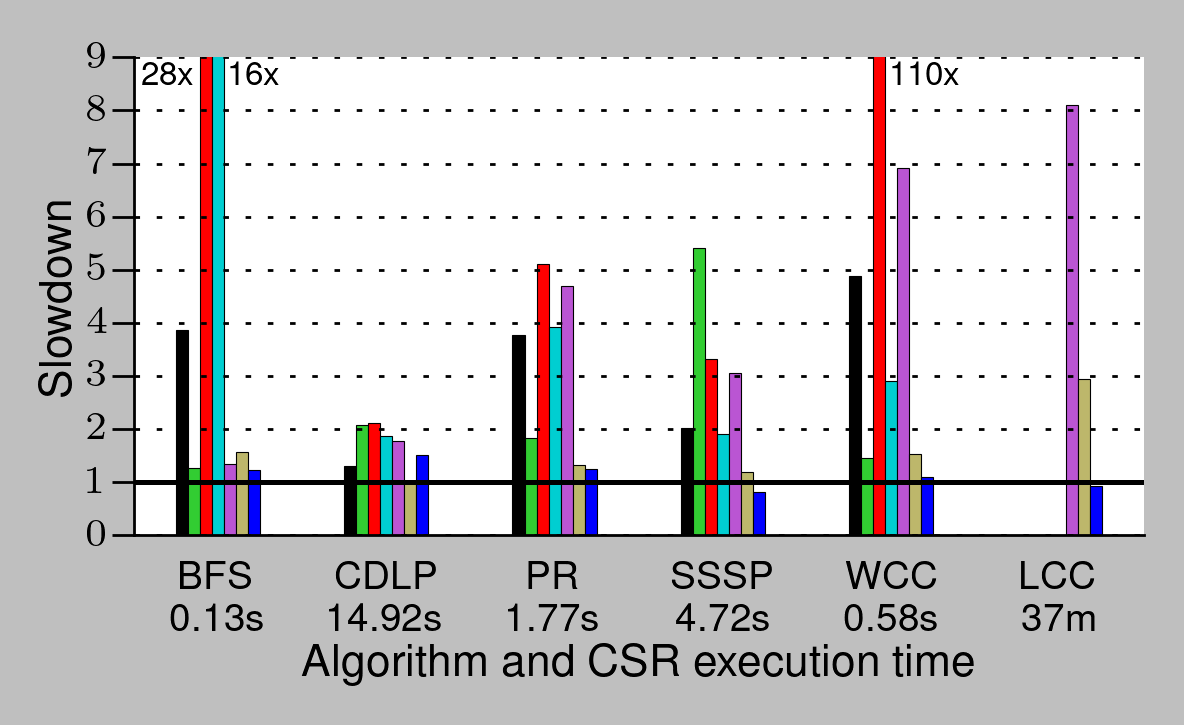

In [17]:
## FIGURE 11a
v = speedups.copy()
v = v.query("graph in 'graph500-24'")
v = v.query("library in ['graphone','sortledton', 'llama', 'teseo_logical', 'teseo_real', 'stinger', 'livegraph']")

#d['sorted_systems'] = [3, 4, 0, 2, 1, 5, 6]
#d = d.sort_values('sorted_systems')

v = v.transpose()
colormap=common.set_library_colormap('graph500-24')
plotting.latexify(fig_width=3.0)

p = v.plot.bar(color=colormap, linewidth=0.2)

p.set_ylim(0, 9)

plt.ylabel("Slowdown")
plt.xlabel("Algorithm and CSR execution time")

plt.legend().remove()

plt.xticks(rotation=0)
positions = (0, 1, 2, 3, 4,5)
# Numbers are execution times of min_csr
x_labels = ("BFS \n0.13s", "CDLP \n14.92s", "PR \n1.77s", "SSSP \n4.72s", "WCC \n0.58s", "LCC \n37m")
plt.xticks(positions, x_labels)

plt.text(0.75, 0.875, "110x", fontsize=OVERFLOW_FONT_SIZE, transform=plt.gcf().transFigure)
plt.text(0.198, 0.875, "16x", fontsize=OVERFLOW_FONT_SIZE, transform=plt.gcf().transFigure)
plt.text(0.125, 0.875, "28x", fontsize=OVERFLOW_FONT_SIZE, transform=plt.gcf().transFigure)

plotting.format_axes(p, categorical_x=True)
plotting.add_line_on_1(plt)

plt.tight_layout()
plt.savefig(plotting.base_path + "graphalytics-general-new-graph500.png", dpi=400)

In [18]:
min_csr.query("graph in 'graph500-24'")

algorithm,bfs,cdlp,lcc,pagerank,sssp,wcc,lcc_std
graph,,,,,,,
graph500-24,0.131544,14.926092,51.627964,1.786068,4.717334,0.57657,2236.280409


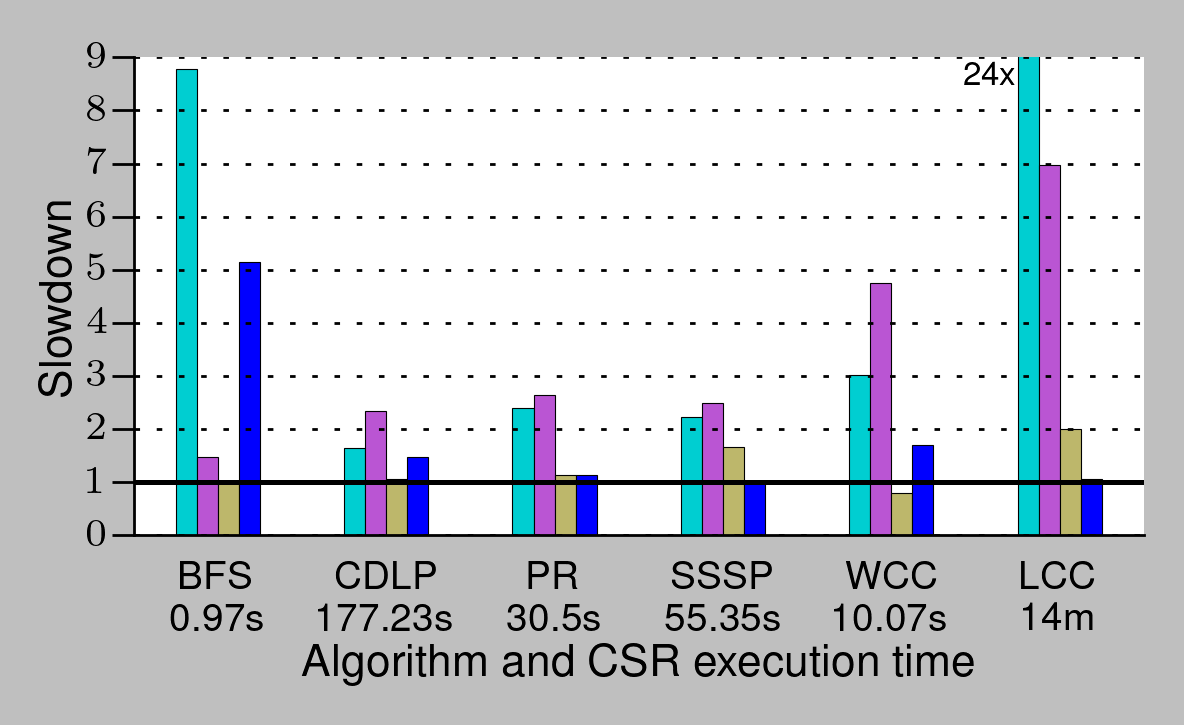

In [19]:
## FIGURE 11b
v = speedups.copy()
v = v.query("graph in 'com-friendster'")
v = v.query("library in ['graphone','sortledton', 'llama', 'teseo_logical', 'teseo_real', 'stinger', 'livegraph']")
v = v.transpose()

colormap=common.set_library_colormap('com-friendster')

plotting.latexify(fig_width=3.0)

p = v.plot.bar(color=colormap, legend=None, linewidth=0.2)

p.set_ylim(0, 9)

plt.ylabel("Slowdown")
plt.xlabel("Algorithm and CSR execution time")

plt.xticks(rotation=0)
positions = (0, 1, 2, 3, 4, 5)
labels = ("BFS \n0.97s", "CDLP \n177.23s", "PR \n30.5s", "SSSP \n55.35s", "WCC \n10.07s", "LCC \n14m")
plt.xticks(positions, labels)

plt.text(0.81, 0.875, "24x", fontsize=OVERFLOW_FONT_SIZE, transform=plt.gcf().transFigure)

plotting.format_axes(p, categorical_x=True)
plotting.add_line_on_1(plt)

plt.tight_layout()
plt.savefig(plotting.base_path + "graphalytics-general-new-friendster.png", dpi=400)

In [20]:
min_csr.query("graph in 'com-friendster'")

algorithm,bfs,cdlp,lcc,pagerank,sssp,wcc,lcc_std
graph,,,,,,,
com-friendster,0.970899,177.237292,59.47015,30.603569,49.037404,10.068403,835.65181


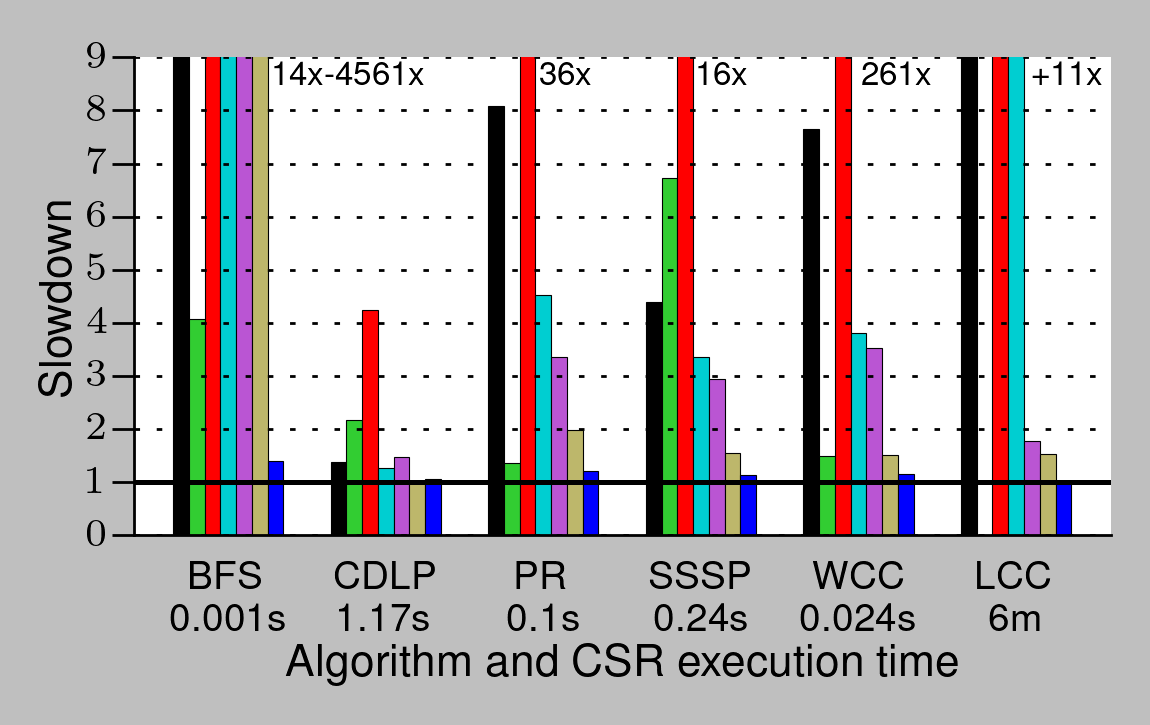

In [21]:
## FIGURE 11c
v = speedups.copy()
v = v.query("graph in ['dota-league']")
v = v.query("library in ['graphone','sortledton', 'llama', 'teseo_logical', 'teseo_real', 'stinger', 'livegraph']")
v = v.transpose()

colormap=common.set_library_colormap('dota-league')
plotting.latexify(fig_width=3.0)

p = v.plot.bar(width=0.7, color=colormap, legend=None, linewidth=0.2)

p.set_ylim(0, 9)


plt.ylabel("Slowdown")
plt.xlabel("Algorithm and CSR execution time")

plt.xticks(rotation=0)
positions = (0, 1, 2, 3, 4, 5)
x_labels = ("BFS \n 0.001s", "CDLP \n 1.17s", "PR \n0.1s", "SSSP \n0.24s", "WCC \n0.024s", "LCC \n6m")
plt.xticks(positions, x_labels)

plt.text(0.867, 0.875, "+11x", fontsize=OVERFLOW_FONT_SIZE, transform=plt.gcf().transFigure)
plt.text(0.725, 0.875, "261x", fontsize=OVERFLOW_FONT_SIZE, transform=plt.gcf().transFigure)
plt.text(0.588, 0.875, "16x", fontsize=OVERFLOW_FONT_SIZE, transform=plt.gcf().transFigure)
plt.text(0.457, 0.875, "36x", fontsize=OVERFLOW_FONT_SIZE, transform=plt.gcf().transFigure)
plt.text(0.235, 0.875, "14x-4561x", fontsize=OVERFLOW_FONT_SIZE, transform=plt.gcf().transFigure)

plotting.format_axes(p, categorical_x=True)
plotting.add_line_on_1(plt)

plt.tight_layout()
plt.savefig(plotting.base_path + "graphalytics-general-new-dota-league.png", dpi=400)

In [22]:
legend_labels = ["Stinger", "Llama", "GraphOne", "Livegraph", "Teseo logical", "Teseo real", "Sortledton"]
legend = p.legend(ncol=7, borderaxespad=0., labels=legend_labels)
fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig("../plots/legend.png", dpi=400, bbox_inches=bbox)


In [23]:
min_csr.query("graph in 'dota-league'")

algorithm,bfs,cdlp,lcc,pagerank,sssp,wcc,lcc_std
graph,,,,,,,
dota-league,0.000727,1.107514,49.816105,0.105036,0.245215,0.023842,363.35308
